In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
52596,00013262_001.png,Cardiomegaly,1,13262,41,F,AP,2500,2048,0.168,0.168,NaN
14570,00003789_006.png,No Finding,6,3789,41,M,AP,2500,2048,0.171,0.171,NaN
73945,00018187_006.png,No Finding,6,18187,32,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5219,00027961_000.png,No Finding,0,27961,061Y,M,PA,1898,1844,0.194311,0.194311
921,00004844_000.png,No Finding,0,4844,042Y,M,PA,2500,2048,0.171000,0.171000
5289,00028505_012.png,Pleural_Thickening,12,28505,032Y,F,PA,2021,2021,0.194311,0.194311


In [4]:
## EDA
## Dataset size 
print(len(all_xray_df))

112120


In [5]:
## Sample Dataset 
print(len(sample_df))

5606


### Distributions of basic demographics

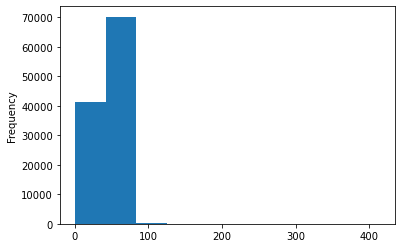

In [6]:
## Age 
all_xray_df['Patient Age'].plot(kind='hist')

In [7]:
max(all_xray_df['Patient Age']) # ??! 

414

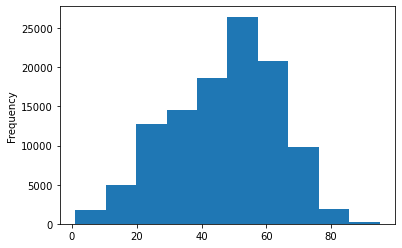

In [8]:
## Remove ages > 100
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]
all_xray_df['Patient Age'].plot(kind='hist')

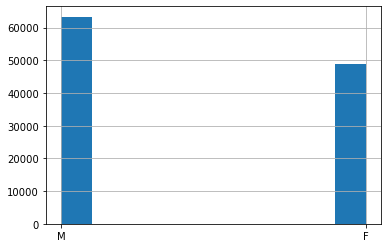

In [9]:
all_xray_df['Patient Gender'].hist()

In [10]:
all_xray_df['Patient Gender'].value_counts()

M    63328
F    48776
Name: Patient Gender, dtype: int64

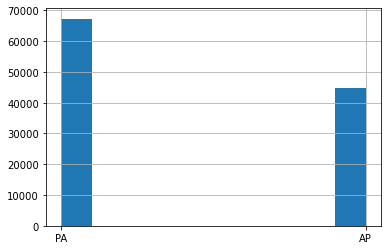

In [11]:
all_xray_df['View Position'].hist()

In [12]:
all_xray_df['View Position'].value_counts()

PA    67299
AP    44805
Name: View Position, dtype: int64

In [13]:
## Decompose findings 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
print("Positive Pneumonia:")
positive_pneumonia = (sum(all_xray_df['Pneumonia'] == 1.0))
print(positive_pneumonia)

print("No Pneumonia:")
no_pneumonia = (sum(all_xray_df['Pneumonia'] == 0.0))
print(no_pneumonia)

print("Ratio pos/neg")
print(positive_pneumonia / no_pneumonia)

Positive Pneumonia:
1430
No Pneumonia:
110674
Ratio pos/neg
0.012920830547373367


The number of cases of pneumonia is small compared to all the cases in the dataset. 

### Distributions of diseases and comorbidities

In [15]:
only_diseases = all_xray_df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']]

In [16]:
only_diseases.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


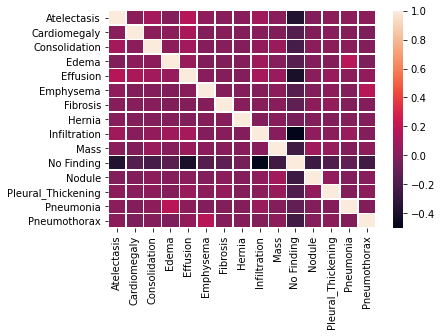

In [17]:
ax = sns.heatmap(only_diseases.corr(), linewidth=0.5, xticklabels = all_labels, yticklabels = all_labels)
plt.show()

Conclusions: 
- The number of pneumonia cases is small in the datasets, in the real world this number can also be small. However, for our model training we should create a training set with the same number of pneumonia and no pneumonia cases. 
- Pneumonia isn't correlated to any other disease, except maybe Edema with a slight correlation.


## Intensity analysis 

In [21]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.head()

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000003_000.png


In [25]:
pneumonia_cases = all_xray_df[all_xray_df.Pneumonia == 1.0].sample(8)
no_pneumonia_cases = all_xray_df[all_xray_df.Pneumonia == 0.0].sample(8)

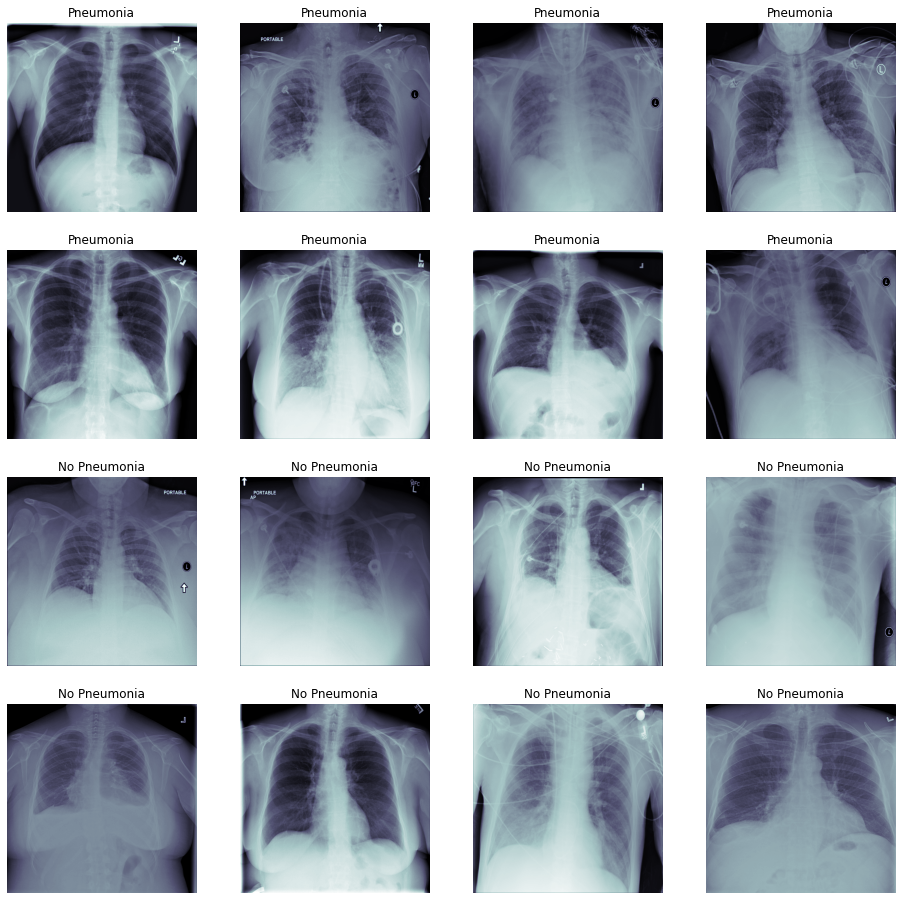

In [41]:
## Visualize some images 
from PIL import Image
path_p = pneumonia_cases["path"].values
path_n = no_pneumonia_cases["path"].values
path = np.concatenate((path_p,path_n), axis=0)
y = ["1"]*8 + ["0"]*8
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(path,y, m_axs.flatten()):
    image = Image.open(c_x)
    c_ax.imshow(image, cmap = 'bone')
    if c_y == "1": 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [39]:
p = path_p[1]
n = path_n[5]

(array([6.9450e+03, 1.6400e+02, 1.2400e+02, 1.2500e+02, 1.1500e+02,
        1.0200e+02, 0.0000e+00, 9.3000e+01, 1.0700e+02, 9.4000e+01,
        1.1200e+02, 9.0000e+01, 9.3000e+01, 0.0000e+00, 9.6000e+01,
        9.7000e+01, 9.8000e+01, 1.1000e+02, 1.1200e+02, 1.0900e+02,
        0.0000e+00, 1.0400e+02, 1.4100e+02, 2.0000e+02, 2.7300e+02,
        2.8000e+02, 2.9900e+02, 0.0000e+00, 2.9600e+02, 2.8500e+02,
        2.6200e+02, 2.4100e+02, 2.2600e+02, 2.4800e+02, 0.0000e+00,
        2.4100e+02, 2.6900e+02, 2.9400e+02, 3.0400e+02, 3.4500e+02,
        3.0500e+02, 0.0000e+00, 3.0800e+02, 2.7000e+02, 2.9700e+02,
        3.3400e+02, 3.6100e+02, 3.5000e+02, 0.0000e+00, 3.7300e+02,
        3.8800e+02, 3.8500e+02, 4.0400e+02, 4.4400e+02, 4.8200e+02,
        0.0000e+00, 5.5900e+02, 5.9800e+02, 7.0400e+02, 8.8600e+02,
        1.0530e+03, 1.2410e+03, 0.0000e+00, 1.6030e+03, 2.0310e+03,
        2.4890e+03, 2.9570e+03, 3.5880e+03, 4.2370e+03, 0.0000e+00,
        4.8800e+03, 5.7180e+03, 6.2970e+03, 7.05

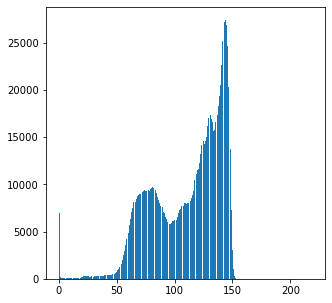

In [49]:
## Intensity for negative pneumonia case
image = Image.open(n)
pix_n = list(image.getdata())
plt.figure(figsize=(5,5))
plt.hist(pix_n, bins = 256)

In [51]:
mean_intensity = np.mean(pix_n)
mean_intensity

111.08678531646729

In [52]:
std_intensity = np.std(pix_n)
std_intensity

30.278359375753016

(array([3.6970e+03, 3.7400e+02, 1.5310e+03, 4.8980e+03, 5.5750e+03,
        6.1420e+03, 5.3290e+03, 8.3150e+03, 1.8526e+04, 2.8920e+03,
        9.0500e+02, 6.6000e+02, 5.3700e+02, 5.8000e+02, 5.4000e+02,
        5.3000e+02, 6.2400e+02, 6.1700e+02, 6.2700e+02, 6.5600e+02,
        7.1800e+02, 8.5300e+02, 8.5700e+02, 8.0200e+02, 8.8000e+02,
        7.8100e+02, 8.9500e+02, 1.0270e+03, 1.2370e+03, 1.0770e+03,
        9.6300e+02, 1.0160e+03, 1.0450e+03, 1.0610e+03, 1.0490e+03,
        1.0190e+03, 1.1020e+03, 1.0810e+03, 1.1310e+03, 1.0250e+03,
        1.0960e+03, 1.1460e+03, 1.2810e+03, 1.3830e+03, 1.4570e+03,
        1.4130e+03, 1.6240e+03, 1.7270e+03, 1.7850e+03, 1.8310e+03,
        1.9520e+03, 1.9550e+03, 2.1470e+03, 2.3050e+03, 2.4630e+03,
        2.6100e+03, 2.8280e+03, 2.9330e+03, 3.2060e+03, 3.2900e+03,
        3.3350e+03, 3.6010e+03, 3.9080e+03, 3.9710e+03, 4.1610e+03,
        4.1390e+03, 4.1660e+03, 4.2770e+03, 4.3150e+03, 4.5090e+03,
        4.8440e+03, 5.1720e+03, 5.3210e+03, 5.60

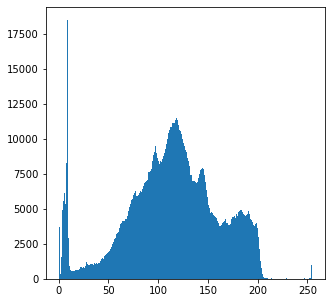

In [50]:
## Intensity for positive pneumonia case
image = Image.open(p)
pix_p = list(image.getdata())
plt.figure(figsize=(5,5))
plt.hist(pix_p, bins = 256)

In [53]:
mean_intensity = np.mean(pix_p)
mean_intensity

113.67920017242432

In [54]:
std_intensity = np.std(pix_p)
std_intensity

47.72043332742931

Between the two images, there is no clear difference in the mean and std of the two distributions. However, we can clearly see that the peak in the pixel intensity are different. Overall, the pixel intensity level of pneumonia cases are lower than the normal. 